In [1]:
########### Setup ###############
!pip install lime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bffcde87c93eee5681e79d5e78ce697e97d1091920929d8fb1c8342b18e95aba
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [7]:
########## Evaluation Function ##############
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()



def run_models(X_train, y_train, X_test, y_test, title=""):

    models = {
        "Random Forest": RandomForestClassifier(random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    }

    print(f"\n{'='*10} {title} {'='*10}")
    for name, model in models.items():
        model.fit(X_train, y_train)
        evaluate_model(name, model, X_test, y_test)



========== Non-Textual Features ==========

Model: Random Forest
Accuracy: 0.6759314456035768
Precision: 0.6909323116219668
Recall: 0.66736811552137
F1 Score: 0.6789458142625129
ROC AUC: 0.7447988351182557


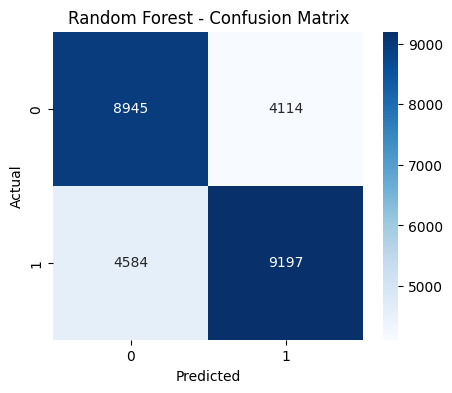

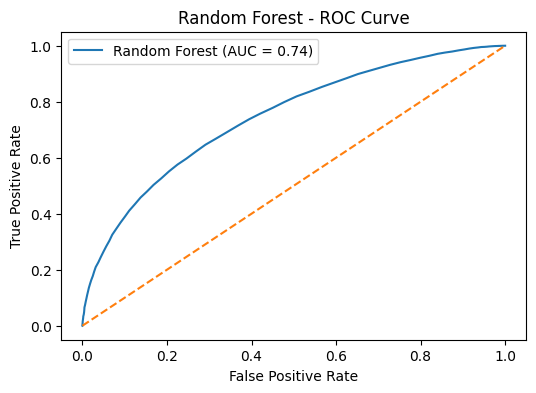


Model: Logistic Regression
Accuracy: 0.621274217585693
Precision: 0.6264512519233459
Recall: 0.6499528336114941
F1 Score: 0.637985683250828
ROC AUC: 0.6659594389451581


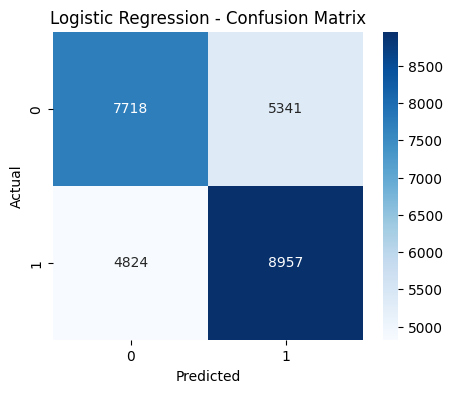

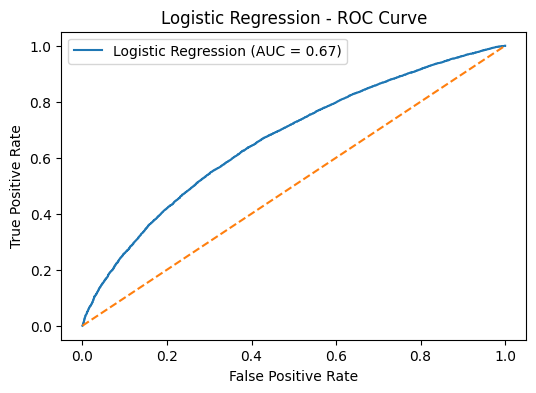


Model: XGBoost
Accuracy: 0.6883755588673621
Precision: 0.6995505783540853
Recall: 0.688992090559466
F1 Score: 0.694231191050669
ROC AUC: 0.7596106764097472


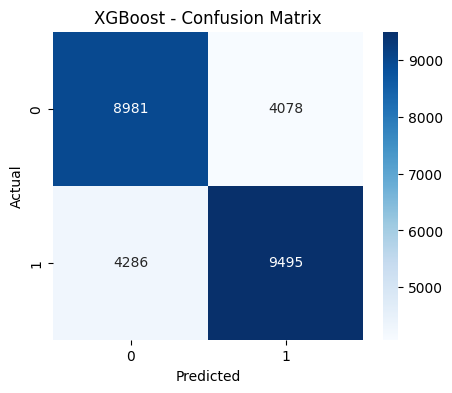

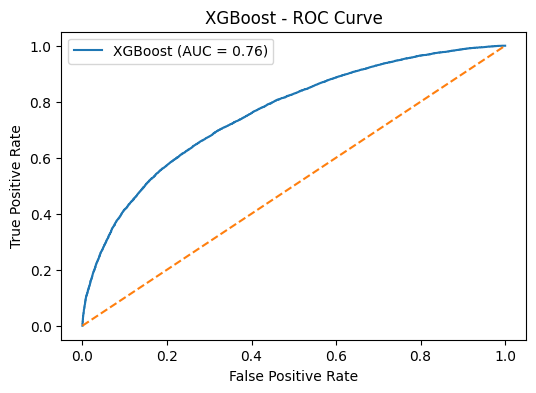


========== Textual Features (TF-IDF) ==========

Model: Random Forest
Accuracy: 0.9399776453055142
Precision: 0.9431900946831755
Recall: 0.9396995863870546
F1 Score: 0.9414416051761114
ROC AUC: 0.9565491755810271


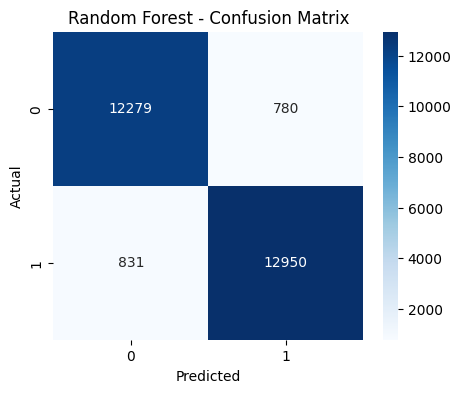

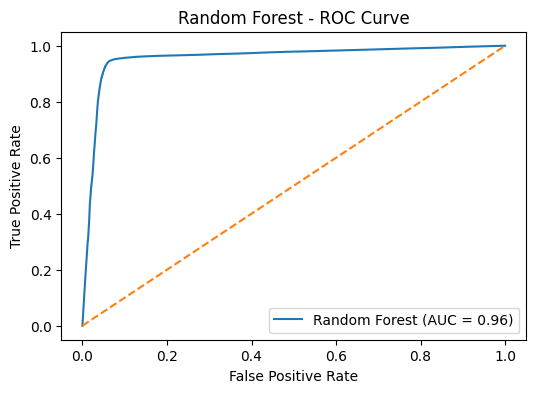


Model: Logistic Regression
Accuracy: 0.931408345752608
Precision: 0.9309846953508518
Recall: 0.9357811479573326
F1 Score: 0.9333767596714074
ROC AUC: 0.9535005288413267


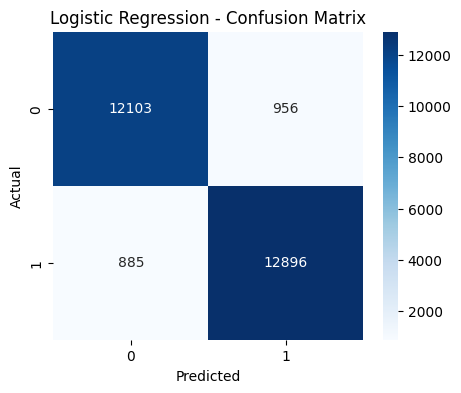

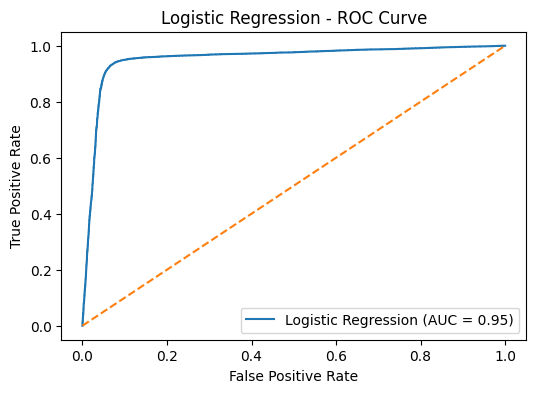


Model: XGBoost
Accuracy: 0.9299180327868852
Precision: 0.9212687623902577
Recall: 0.9441985342137725
F1 Score: 0.9325927253180434
ROC AUC: 0.9514143579246398


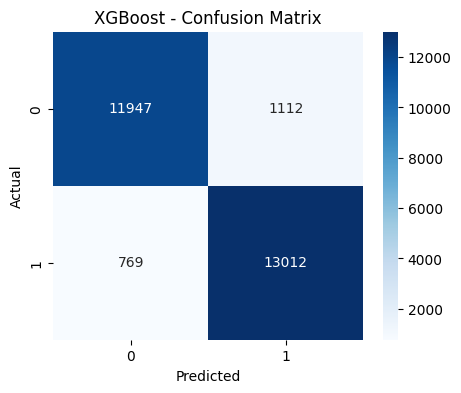

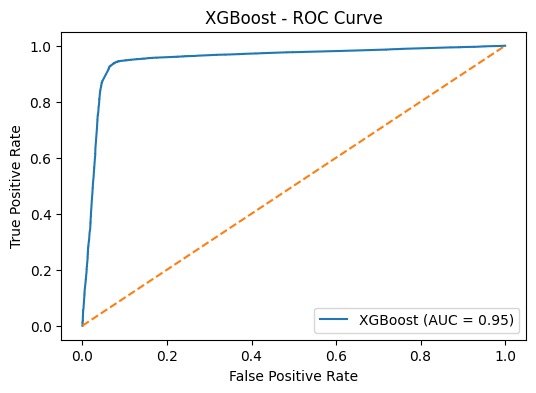


========== Combined Features (TF-IDF + Non-Textual) ==========

Model: Random Forest
Accuracy: 0.9256333830104322
Precision: 0.9210432297249017
Recall: 0.9353457659095856
F1 Score: 0.928139400921659
ROC AUC: 0.9528660759453452


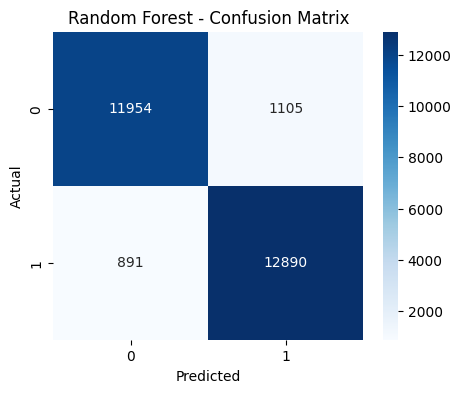

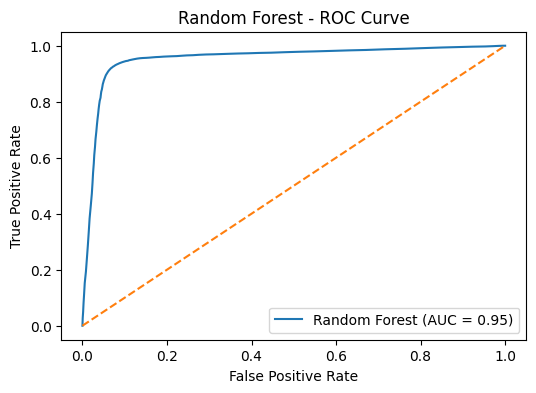


Model: Logistic Regression
Accuracy: 0.9338301043219076
Precision: 0.9336126562161381
Recall: 0.937812930846818
F1 Score: 0.9357080799304952
ROC AUC: 0.954125654979681


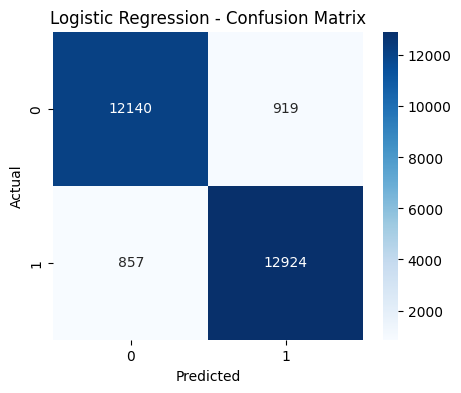

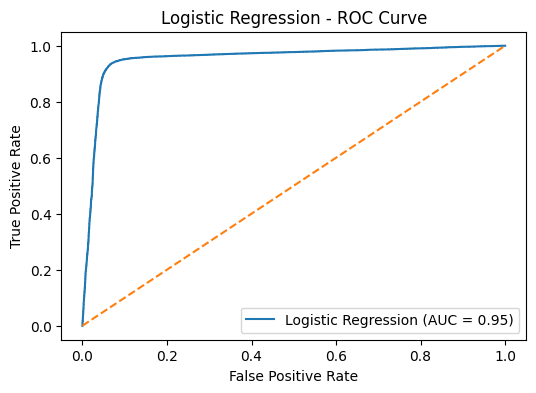


Model: XGBoost
Accuracy: 0.9263412816691505
Precision: 0.9169845979935001
Recall: 0.9418039329511646
F1 Score: 0.929228566314659
ROC AUC: 0.9514845850478301


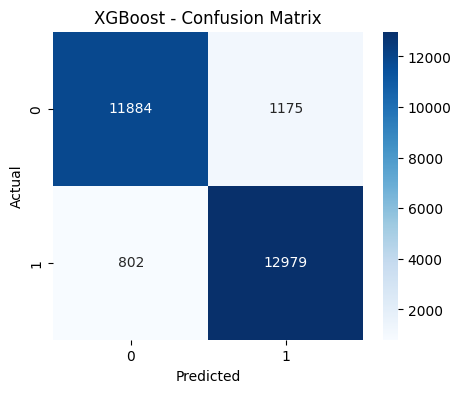

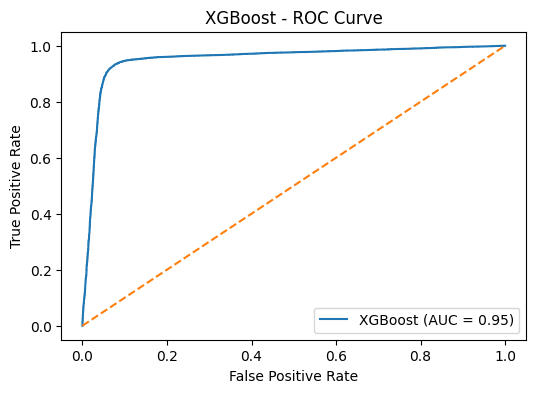

In [9]:
############ Preprocessing ###############
df = pd.read_csv("Twitter_Analysis.csv")
df['majority_target'].value_counts()

# First, we decide to remove unnecessary columns, including the index,
# In this dataset there are 2 types of labels, majority target and binary decision. We decided to choose the majority target as the true label
df.drop(['BinaryNumTarget', 'Unnamed: 0'], axis=1, inplace=True)

# In the pre-processing stage we remove all not publicly accessible user-level features
df.drop([
    'BotScore',
    'BotScoreBinary',
    'cred',
    'normalize_influence',
    'mentions',
    'quotes',
    'replies',
    'retweets',
    'favourites',
    'embeddings',
    'statement'
], axis=1, inplace=True)


# Ensure target is integer
df['majority_target'] = df['majority_target'].astype(int)
y = df['majority_target']

# Define features
textual_features = ['tweet']
non_textual_features = df.drop(columns=['majority_target'] + textual_features, errors='ignore').columns.tolist()


##########################################
# -------- 1. Non-Textual Only ----------
##########################################
X_non_textual = df[non_textual_features].copy()
scaler = MinMaxScaler()
X_non_textual_scaled = scaler.fit_transform(X_non_textual)

X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(X_non_textual_scaled, y, test_size=0.2, random_state=42)

run_models(X_train_nt, y_train_nt, X_test_nt, y_test_nt, title="Non-Textual Features")


##########################################
# -------- 2. Textual Only (TF-IDF) -----
##########################################
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X_textual = tfidf.fit_transform(df['tweet'])

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_textual, y, test_size=0.2, random_state=42)

run_models(X_train_t, y_train_t, X_test_t, y_test_t, title="Textual Features (TF-IDF)")


##########################################
# -------- 3. Combined -------------------
##########################################
X_combined = hstack([X_textual, X_non_textual_scaled])
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_combined, y, test_size=0.2, random_state=42)

run_models(X_train_c, y_train_c, X_test_c, y_test_c, title="Combined Features (TF-IDF + Non-Textual)")


In [10]:
# Train the Logistic Regression model on the combined features that we found to have the best results
# Runs Grid search to find the best hyperparameters
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500]
}

# Initialize base Logistic Regression model
# Set random_state for reproducibility
log_reg = LogisticRegression(random_state=42)

# Set up grid search
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Logistic Regression parameters found:", grid_search.best_params_)

# Best Logistic Regression parameters found: {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression parameters found: {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}


In [11]:
########## LIME for Text (TF-IDF) #############
from lime.lime_text import LimeTextExplainer


# Create a prediction function for LIME
class_names = ['Not Fake', 'Fake']
lime_explainer = LimeTextExplainer(class_names=class_names)

# Example explanation
i = 20  # index of instance to explain
text_instance = df['tweet'].iloc[i]
current_non_textual_features = X_non_textual_scaled[i].reshape(1, -1) # Reshape for hstack

def predict_proba_lime(texts):
    # Transform the text using TF-IDF
    tfidf_features = tfidf.transform(texts)

    # For each textual perturbation generated by LIME, we need to combine it
    # with the *original* non-textual features of the instance being explained.
    # Since LIME will pass a list of texts (even if it's just one for the original instance),
    # we need to stack the non-textual features for each text.
    num_texts = tfidf_features.shape[0]
    repeated_non_textual_features = np.tile(current_non_textual_features, (num_texts, 1))

    # Combine textual and non-textual features
    combined_features_for_lime = hstack([tfidf_features, repeated_non_textual_features])

    return best_model.predict_proba(combined_features_for_lime)

exp = lime_explainer.explain_instance(text_instance, predict_proba_lime, num_features=10)
exp.show_in_notebook()

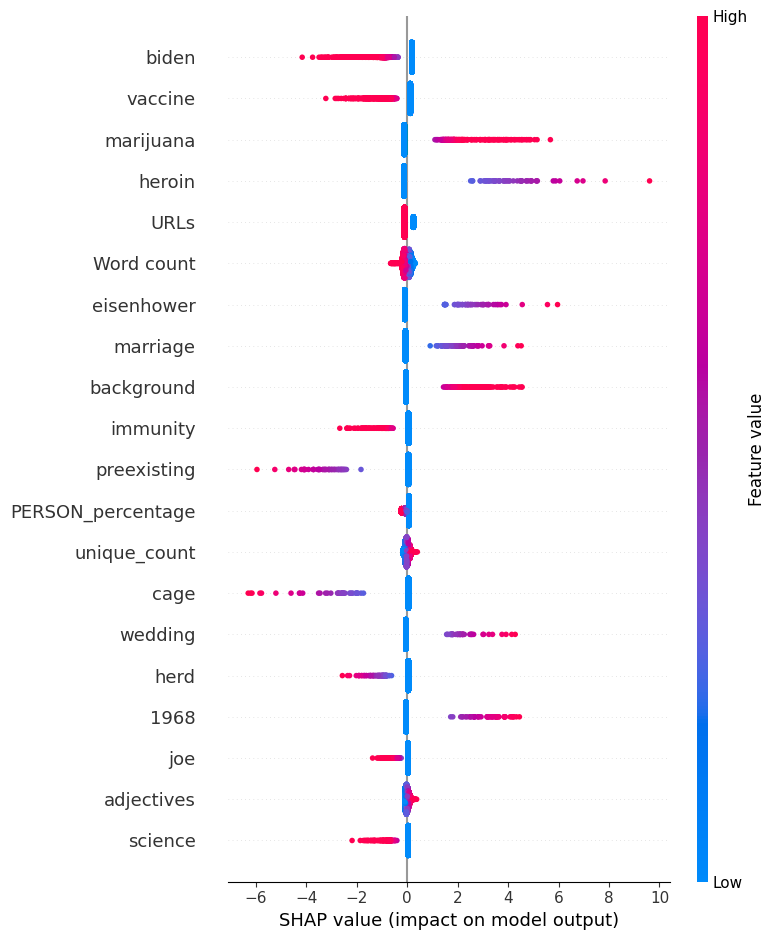

In [12]:
import shap



# Use a smaller subset to avoid memory overload
X_train_dense = X_train[:100000].toarray()  # Convert to dense
X_test_dense = X_test[:10000].toarray()

# SHAP works now
explainer = shap.Explainer(best_model, X_train_dense)
shap_values = explainer(X_test_dense)

# Build feature names list
feature_names = tfidf.get_feature_names_out().tolist() + non_textual_features

# Plot summary
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names)
